In [1]:
from tqdm import tqdm, trange
from time import time
from scipy.interpolate import interp1d
from libsvm.svmutil import svm_read_problem # https://blog.csdn.net/u013630349/article/details/47323883

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline

## Plot functions

In [2]:
def plot_single(seq, xlabel='Iteration', ylabel='Gradient Norm', title=''):
    plt.figure()
    iterations = np.arange(len(seq))+1
    plt.semilogy(iterations,seq)
    plt.xticks(iterations)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# 
def plot_multi_seqs(seqs, xlabel='Iteration', ylabel='Gradient Norm', title='', xtick_step = 50):
    plt.figure(figsize=(16,8), dpi=150)
    maxLen = 0
    for seq in seqs:
        iterations = seq.index
        if iterations.size > maxLen:
            maxLen = iterations.size
        plt.semilogy(iterations, seq, label=seq.name)
    plt.xticks(np.arange(stop=maxLen,step=xtick_step)+1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## Data reader

In [3]:
def read_data(path):
    b, A = svm_read_problem(path)
    rows = len(b)   # 矩阵行数, i.e. sample 数
    cols = max([max(row.keys()) if len(row)>0 else 0 for row in A])  # 矩阵列数, i.e. feature 数
    b = np.array(b)
    A_np = np.zeros((rows,cols))
    for r in range(rows):
        for c in A[r].keys():
            # MatLab 是 1-index, python 则是 0-index
            A_np[r,c-1] = A[r][c]
    # 清楚全 0 features
    effective_row_ids = []
    for idx, row in enumerate(A_np):
        if np.sum(row) > 1e-3:
            effective_row_ids.append(idx)
    return b[effective_row_ids], A_np[effective_row_ids]

b, A = read_data('w8a')
m,n = A.shape
m,n

(45546, 300)

## Related Functions

令 $g_i(x)=\exp(b_i x^\top a_i), i=1,2,...,m$

所以可以得到目标函数为:
$$
f(x)=\frac{1}{m}\sum_{i=1}^{m}\log\left( 1+ \frac{1}{g_i(x)}\right) + \frac{1}{100m}\left\|x\right\|^2
$$
进而可以得到梯度 $\nabla f(x)$ 和 Hessian矩阵 $\nabla^2 f(x)$ 的形式:
$$
\nabla f(x) = \frac{1}{m}\sum_{i=1}^{m}\left[ -b_i a_i (1+g_i(x))^{-1} \right] + \frac{1}{50m}x
$$
$$
\nabla^2 f(x) =  \frac{1}{m}\sum_{i=1}^{m}\left( b_i^2 \frac{g_i(x)}{(1+g_i(x))^2}a_i a_i^\top \right) + \frac{1}{50m}I
$$

此处函数内的 $a_i,b_i$ 和数据本身相关

In [4]:
lamda = 100

def f(x):
    bAx = b*(A@x)
    exp_mbAx = np.exp(-bAx)
    log1p_exp = np.log(1+exp_mbAx)
    overflow_idxs = np.where(exp_mbAx==float('inf'))
    log1p_exp[overflow_idxs] = -bAx[overflow_idxs]
    return log1p_exp.mean() + 1/(lamda*m)* x.T@x

def f_grad(x):
    return np.ones(m)@(np.expand_dims((-b)/(1+np.exp(b*(A@x))), axis=1)*A)/m + 2/(lamda*m)*x

def f_hessian(x):
    Ax = A@x
    exp_bAx = np.exp(b*Ax)
    return (A.T @ (np.expand_dims(b*b*exp_bAx/(1+exp_bAx)**2, axis=1)*A) )/m + 2/(lamda*m)*np.eye(x.size)

## Baselines

### Linear Search (Armijo)

In [5]:
#* Armijo rule 
def armijo_search(f, f_grad, xk, t_hat, alpha, beta, D, isNewton=False, dk=None):
    if isNewton:
        assert dk is not None
    tk = t_hat*1
    grad = f_grad(xk)
    while True:
        if isNewton:
            if np.linalg.norm(xk+tk*dk,ord=2)<=D/2 and f(xk+tk*dk) <= f(xk) + alpha*tk*grad.T@dk:
                break
        else:
            # if np.linalg.norm(xk-tk*grad,ord=2)<=D/2 and f(xk-tk*grad) <= f(xk)-alpha*tk*grad.T@grad:
            if f(xk-tk*grad) <= f(xk)-alpha*tk*grad.T@grad:
                break
        tk *= beta
    return tk


### Newton (Interior Point Methods)

logarithmic barrier:
$$
\phi(x)=-\log(-g(x)),\quad g(x)=\left\|x\right\|_2 - D/2
$$
$$
\nabla g(x) = x/\left\|x\right\|_2, \quad \nabla^2 g(x)= \left\|x\right\|_2^{-1}I-\left\|x\right\|_2^{-3}xx^\top
$$
gradient and hessian:
$$
\nabla \phi(x) = \frac{1}{-g(x)}\nabla g(x)=\frac{x/\left\|x\right\|_2}{D/2-\left\|x\right\|_2}=\frac{x}{\left\|x\right\|_2(D/2-\left\|x\right\|_2)}
$$
$$
\nabla^2\phi(x)=\frac{1}{g(x)^2}\nabla g(x)\nabla g(x)^\top + \frac{1}{-g(x)}\nabla^2 g(x) = \frac{1}{\left\|x\right\|_2(D/2-\left\|x\right\|_2)}I+\frac{2\left\|x\right\|_2-D/2}{\left\|x\right\|_2^3(D/2-\left\|x\right\|_2)^2}xx^\top
$$
central path - for $t>0$:
$$
\min_x tf(x)+\phi(x)
$$

In [12]:
def phi(x,D):
    return -np.log(D/2-np.linalg.norm(x,ord=2))

def phi_grad(x,D):
    x_norm = np.linalg.norm(x,ord=2)
    return x/(x_norm*(D/2-x_norm))

def phi_hessian(x,D):
    x_norm = np.linalg.norm(x,ord=2)
    xxT = np.matmul(x[:,None],x[None,:])    # x * xT
    return np.eye(x.size)/(x_norm*(D/2-x_norm)) + (2*x_norm-D/2)/(x_norm**3 * (D/2-x_norm)**2)*xxT


#* 外部迭代
def barrier_method(t_init, f, f_grad, f_hessian, phi, phi_grad, phi_hessian, A, b, x0, D, num_constraints, mu,
                        method='newton', epsilon=1e-6, maxIter=20):
    xt = x0
    t = t_init
    duality_gaps = []
    func_val_record = []
    t_s = time()
    for i in range(maxIter):
        xt,num_newton_step, fvals = solve_central(objective=f,
                                f=lambda x:t*f(x)+phi(x,D), 
                                f_grad=lambda x:t*f_grad(x)+phi_grad(x,D), 
                                f_hessian=lambda x:t*f_hessian(x)+phi_hessian(x,D),
                                x0=xt, D=D, method=method, epsilon=epsilon*1e3)
        duality_gaps.extend([num_constraints/t]*num_newton_step)
        func_val_record.extend(fvals)
        if num_constraints/t < epsilon:
            break
        t *= mu
    t_e = time()
    return xt, t_e-t_s, np.array(duality_gaps), np.array(func_val_record)

def solve_central(objective, f, f_grad, f_hessian, x0, D, method='newton', epsilon=1e-6, max_iter=50):
    if method == 'newton':
        return damped_newton(objective, f=f, f_grad=f_grad, f_hessian=f_hessian, x0=x0, D=D, epsilon=epsilon, max_iter=max_iter)
    if method == 'bfgs':
        return bfgs(objective, f=f, f_grad=f_grad, f_hessian=f_hessian, x0=x0, D=D, epsilon=epsilon, max_iter=max_iter)


#* 阻尼牛顿
def damped_newton(objective, f, f_grad, f_hessian, x0, D, epsilon=1e-6, max_iter=50):
    xk = x0
    iter_cnt = 0
    fvals = []
    for idx in range(max_iter):
        iter_cnt += 1
        fvals.append(objective(xk))
        grad = f_grad(xk)
        hessian = f_hessian(xk)
        dk = -np.linalg.inv(hessian)@grad
        decrement = (-grad@dk)**0.5
        if decrement**2/2 <= epsilon:
            print('** End The Loop - Iter Cnt.:',iter_cnt, 'Decrement:',decrement, 'fval:',f(xk))
            return xk, iter_cnt, fvals
        tk = armijo_search(f, f_grad, xk, t_hat=1, alpha=0.1, beta=0.5, D=D, isNewton=True, dk=dk)
        print('Iter Cnt.:',iter_cnt, 'Decrement:',decrement, 'fval:',f(xk), 'tk:',tk)
        xk += tk*dk
    return xk, iter_cnt, fvals

#* 拟牛顿
def bfgs(objective, f, f_grad, f_hessian, x0, D, alpha=0.1, beta=0.5, epsilon=1e-6, max_iter=500):
    xk = x0
    hessian = f_hessian(x0)
    mat_k = np.linalg.inv(hessian) 
    # mat_k = np.eye(n) 
    iter_cnt = 0
    fvals = []
    for idx in range(max_iter):
        iter_cnt += 1
        grad_k = f_grad(xk)
        dk = -mat_k@grad_k 
        tk = wolfe_condition(f, f_grad, xk, dk, D, c1=1e-4, c2=0.9)
        if tk<0:
            return xk, iter_cnt-1, fvals
        fvals.append(objective(xk))
        sk = tk*dk
        xk_next = xk + sk
        grad_next = f_grad(xk_next)
        # if np.linalg.norm(grad_next, ord=2) <= epsilon:
        if np.linalg.norm(grad_next, ord=2) <= epsilon or np.linalg.norm(xk_next)>=D/2-1e-2:
            return xk_next, iter_cnt, fvals
        else:
            print(f'Iteration {iter_cnt} - grad_norm:',np.linalg.norm(grad_next),"tk:",tk, "x_norm:",np.linalg.norm(xk_next))
        # mat_k = np.linalg.inv(f_hessian(xk_next))
        mat_k = update_approximation_bfgs(mat=mat_k, sk=sk, yk=grad_next-grad_k)
        xk = xk_next
    return xk_next, iter_cnt, fvals
        
def update_approximation_bfgs(mat, sk, yk, mat_type='H'):
    rhok = 1/(yk@sk)
    if mat_type == 'H':
        Hkyk = mat@yk
        ykTHkyk = yk@Hkyk
        HkykskT = Hkyk[:,None]@sk[None,:]
        skskT = sk[:,None]@sk[None,:]
        mat_new = mat + rhok*((rhok*ykTHkyk+1)*skskT - HkykskT - HkykskT.T)
    else:
        Bksk = mat@sk
        skTBksk = sk@Bksk
        mat_new = mat - Bksk[:,None]@Bksk[None,:]/skTBksk + yk[:,None]@yk[None,:]*rhok
    return mat_new

#* 拟牛顿方法 - 选择步长
def wolfe_condition(f, f_grad, xk, pk, D, c1=1e-4, c2=0.9, multiplier=1.2, t0=0, tmax=2):
    ### 
    while (np.linalg.norm(xk+tmax*pk)>=D/2):
        tmax /= 2
        # print('tmax:',tmax)
        if tmax<1e-6:
            # print('too small stepsize')
            return -1
    ###
    ti = tmax/2
    tprev = t0
    i = 1
    fval_cur = f(xk)
    grad_cur = f_grad(xk)
    while True:
        xk_next = xk+ti*pk
        fval_next = f(xk_next)
        if (fval_next > fval_cur + c1*ti*grad_cur@pk) or (fval_next >= fval_cur and i>1):
            return zoom(f, f_grad, xk, pk, fval_cur, grad_cur, c1, c2, tprev, ti)
        grad_next = f_grad(xk_next)
        grad_next_T_pk = grad_next@pk
        if np.abs(grad_next_T_pk) <= -c2*grad_cur@pk:
            return ti
        if grad_next_T_pk >= 0:
            return zoom(f, f_grad, xk, pk, fval_cur, grad_cur, c1, c2, ti, tprev)
        tprev = ti
        ti = tprev*multiplier
        i += 1

def zoom(f, f_grad, xk, pk, fval, grad, c1, c2, t_lo, t_hi):
    while True:
        # print(f"t_lo: {t_lo}\tt_hi: {t_hi}")
        t = (t_lo+t_hi)/2
        xk_next = xk + t*pk
        fval_next = f(xk_next)
        if fval_next > fval + c1*t*grad@pk or fval_next >= f(xk+t_lo*pk):
            t_hi = t
        else:
            grad_next = f_grad(xk_next)
            grad_next_T_pk = grad_next@pk
            if np.abs(grad_next_T_pk) <= -c2*grad@pk:
                return t
            if grad_next_T_pk*(t_hi-t_lo)>=0:
                t_hi = t_lo
            t_lo = t
        if t_lo == t_hi: # 死循环
            return -1
     
        

In [10]:
np.random.seed(1000)
# D=20
t_init = 1
x0 = np.zeros(n)+0.005
x_opt_ipm_damped, t_ipm_damped, duality_gaps_damped, fvals_damped = barrier_method(t_init=t_init, f=f, f_grad=f_grad, f_hessian=f_hessian, phi=phi, phi_grad=phi_grad, phi_hessian=phi_hessian, 
                A=A, b=b, x0=x0, D=20, num_constraints=1, method='newton', mu=10, epsilon=1e-6, maxIter=20)
print(f'最小值: {f(x_opt_ipm_damped):>2f}\t耗时: {t_ipm_damped:>2f}s')

Iter Cnt.: 1 Decrement: 0.9525578038914555 fval: -1.569533749629282 tk: 1
Iter Cnt.: 2 Decrement: 0.6084895374423559 fval: -1.7498984994316462 tk: 0.5
Iter Cnt.: 3 Decrement: 0.12992597126245592 fval: -1.8633527068729119 tk: 1
** End The Loop - Iter Cnt.: 4 Decrement: 0.02321306437254386 fval: -1.8726656070316618
Iter Cnt.: 1 Decrement: 1.0792049141682987 fval: 0.647848502583277 tk: 1
Iter Cnt.: 2 Decrement: 0.6100747846231196 fval: -0.08446265646887308 tk: 1
Iter Cnt.: 3 Decrement: 0.23545159529444123 fval: -0.3070194485297655 tk: 1
** End The Loop - Iter Cnt.: 4 Decrement: 0.03707000873467996 fval: -0.33731360473380945
Iter Cnt.: 1 Decrement: 2.185111949659234 fval: 12.3868314478077 tk: 1
Iter Cnt.: 2 Decrement: 0.6861200416531448 fval: 9.862690130100074 tk: 1
Iter Cnt.: 3 Decrement: 0.1074930906532772 fval: 9.60733766618385 tk: 1
** End The Loop - Iter Cnt.: 4 Decrement: 0.004044385787036891 fval: 9.601432568933406
Iter Cnt.: 1 Decrement: 4.7492332061745826 fval: 101.25102919604771 

In [14]:
np.random.seed(1000)
# D=20
t_init = 1
x0 = np.zeros(n)+0.005
x_opt_ipm_bfgs, t_ipm_bfgs, duality_gaps_bfgs, fvals_bfgs = barrier_method(t_init=t_init, f=f, f_grad=f_grad, f_hessian=f_hessian, phi=phi, phi_grad=phi_grad, phi_hessian=phi_hessian, 
                A=A, b=b, x0=x0, D=20, num_constraints=1, method='bfgs', mu=10, epsilon=1e-6, maxIter=20)
print(f'最小值: {f(x_opt_ipm_bfgs):>2f}\t耗时: {t_ipm_bfgs:>2f}s')

Iteration 1 - grad_norm: 0.16436546152681786 tk: 1.0 x_norm: 1.895870645724538
Iteration 2 - grad_norm: 0.14891025638579403 tk: 1.2 x_norm: 1.6123917628543183
Iteration 3 - grad_norm: 0.07502011871157341 tk: 0.5 x_norm: 0.9970644876961946
Iteration 4 - grad_norm: 0.05610577996870103 tk: 1.0 x_norm: 1.0941712317097694
Iteration 5 - grad_norm: 0.014832457759573174 tk: 1.0 x_norm: 1.3777964276903911
Iteration 6 - grad_norm: 0.010120591705236754 tk: 1.0 x_norm: 1.4373307072874
Iteration 7 - grad_norm: 0.008785266082478564 tk: 1.0 x_norm: 1.4558377622885526
Iteration 8 - grad_norm: 0.006119698831746697 tk: 1.0 x_norm: 1.4713877021416755
Iteration 9 - grad_norm: 0.0031432242900151616 tk: 1.0 x_norm: 1.4686542555331454
Iteration 10 - grad_norm: 0.0015329498593511898 tk: 1.0 x_norm: 1.4568608633253517
Iteration 11 - grad_norm: 0.0012077880680353415 tk: 1.0 x_norm: 1.4511717558898638
Iteration 12 - grad_norm: 0.001027187177675304 tk: 1.0 x_norm: 1.4491015164638759
Iteration 1 - grad_norm: 0.378

In [15]:
f(x_opt_ipm_bfgs)-f(x_opt_ipm_damped)

1.647958966233265e-07

Pure damped newton w/o constraints (D=500)

In [16]:
#* pure阻尼牛顿
def pure_damped_newton(f, f_grad, f_hessian, x0, D, epsilon=1e-6, max_iters=100):
    func_val_record = []
    grad_norm_record = []
    xk = x0
    t_s = time()
    # for idx in trange(max_iters):
    for idx in range(max_iters):
        grad = f_grad(xk)
        # print(np.linalg.norm(grad))
        hessian = f_hessian(xk)
        # dk = -np.linalg.pinv(hessian)@grad
        dk = -np.linalg.inv(hessian)@grad
        tk = armijo_search(f, f_grad, xk, t_hat=1, alpha=0.1, beta=0.5, D=D, isNewton=True, dk=dk)
        xk_next = xk + tk*dk
        func_val_record.append(f(xk_next))
        # grad_norm_record.append(np.linalg.norm(f_grad(xk_next),ord=2))
        grad_next = np.linalg.norm(f_grad(xk_next),ord=2)
        grad_norm_record.append(grad_next)
        # termination criteria
        if grad_next<=epsilon:
            break
        else:
            print('grad_norm:',grad_next,"tk:",tk, "x_norm:",np.linalg.norm(xk_next))
        xk = xk_next
    t_e = time()
    return xk_next, np.asarray(func_val_record), np.asarray(grad_norm_record), t_e-t_s

np.random.seed(1000)

# init_x = np.zeros(n)+0.5
init_x = np.zeros(n)+0.005

# D=500 半径足够大，本质上是无约束
x_opt_damped, _, _, t_damped = pure_damped_newton(f=f, f_grad=f_grad, f_hessian=f_hessian, x0=init_x, D=500, epsilon=1e-8, max_iters=50)
print(f'最小值: {f(x_opt_damped):>2f}\t耗时: {t_damped:>2f}s')

grad_norm: 0.18017720987362976 tk: 1 x_norm: 11.165278301280532
grad_norm: 0.07430235763542076 tk: 1 x_norm: 18.78206938371404
grad_norm: 0.03121190141848213 tk: 1 x_norm: 27.44040477856484
grad_norm: 0.012796497780903252 tk: 1 x_norm: 36.77727415441325
grad_norm: 0.004894660242605477 tk: 1 x_norm: 45.9257331177887
grad_norm: 0.0016353055256952348 tk: 1 x_norm: 54.13674948486485
grad_norm: 0.0004390302509728913 tk: 1 x_norm: 60.10520617618396
grad_norm: 9.125726807373675e-05 tk: 1 x_norm: 63.53445177996058
grad_norm: 2.4768185298650292e-05 tk: 1 x_norm: 65.32760767837152
grad_norm: 6.8735057881137935e-06 tk: 1 x_norm: 66.52694639503159
grad_norm: 1.2104066887873718e-06 tk: 1 x_norm: 67.1480388626449
grad_norm: 9.161945407374053e-08 tk: 1 x_norm: 67.27924417413054
最小值: 0.058278	耗时: 2.872031s


Pure quasi newton w/o constraints (D=500) 

In [87]:
#* 拟牛顿
def quasi_newton_bfgs(f, f_grad, f_hessian, x0, mat_type='H', alpha=0.1, beta=0.5, epsilon=1e-6, max_iters=500):
    assert mat_type in ['H','B']
    xk = x0
    hessian = f_hessian(x0)
    mat_k = np.linalg.inv(hessian) if mat_type=='H' else hessian
    iter_cnt = 0
    t_s = time()
    for idx in range(max_iters):
        iter_cnt += 1
        grad_k = f_grad(xk)
        dk = -mat_k@grad_k if mat_type=='H' else -np.linalg.inv(mat_k)@grad_k
        tk = wolfe_condition(f, f_grad, xk, dk, c1=1e-4, c2=0.9)
        sk = tk*dk
        xk_next = xk + sk
        grad_next = f_grad(xk_next)
        if np.linalg.norm(grad_next, ord=2) <= epsilon:
            return xk_next, iter_cnt, time()-t_s
        else:
            print(f'Iteration {iter_cnt} - grad_norm:',np.linalg.norm(grad_next),"tk:",tk, "x_norm:",np.linalg.norm(xk_next))
        # mat_k = np.linalg.inv(f_hessian(xk_next))
        mat_k = update_approximation_bfgs(mat=mat_k, sk=sk, yk=grad_next-grad_k, mat_type=mat_type)
        xk = xk_next
    return xk_next, iter_cnt, time()-t_s

def wolfe_condition(f, f_grad, xk, pk, c1=1e-4, c2=0.9, multiplier=1.25, t0=0, tmax=2):
    ti = tmax/2
    tprev = t0
    i = 1
    fval_cur = f(xk)
    grad_cur = f_grad(xk)
    while True:
        xk_next = xk+ti*pk
        fval_next = f(xk_next)
        if (fval_next > fval_cur + c1*ti*grad_cur@pk) or (fval_next >= fval_cur and i>1):
            return zoom(f, f_grad, xk, pk, fval_cur, grad_cur, c1, c2, tprev, ti)
        grad_next = f_grad(xk_next)
        grad_next_T_pk = grad_next@pk
        if np.abs(grad_next_T_pk) <= -c2*grad_cur@pk:
            return ti
        if grad_next_T_pk >= 0:
            return zoom(f, f_grad, xk, pk, fval_cur, grad_cur, c1, c2, ti, tprev)
        tprev = ti
        ti = tprev*multiplier
        i += 1

np.random.seed(1000)
init_x = np.zeros(n)+0.005

# 使用 quasi-newton 求解无约束问题
# quasi_newton_bfgs(f, f_grad, f_hessian, x0, mat_type='H', alpha=0.1, beta=0.5, epsilon=1e-6, maxIter=100):
x_opt_bfgs, iter_cnt_bfgs, t_bfgs = quasi_newton_bfgs(f=f, f_grad=f_grad, f_hessian=f_hessian, x0=init_x, mat_type='H', epsilon=1e-4, max_iters=200)
# x_opt_bfgs, iter_cnt_bfgs, t_bfgs = quasi_newton_bfgs(f=f, f_grad=f_grad, f_hessian=f_hessian, x0=init_x, mat_type='B', epsilon=1e-8, max_iters=200)
print(f'BFGS - 迭代次数: {iter_cnt_bfgs}\t最小值: {f(x_opt_bfgs):>2f}\t耗时: {t_bfgs:>2f}s')

Iteration 1 - grad_norm: 0.18017720987362976 tk: 1.0 x_norm: 11.165278301280532
Iteration 2 - grad_norm: 0.11332750219773532 tk: 1.0 x_norm: 15.135338733342227
Iteration 3 - grad_norm: 0.0588887609960591 tk: 1.0 x_norm: 21.533528580786278
Iteration 4 - grad_norm: 0.03370457453496356 tk: 1.0 x_norm: 28.007182606015498
Iteration 5 - grad_norm: 0.018882899036194684 tk: 1.0 x_norm: 35.87806759864599
Iteration 6 - grad_norm: 0.010866841039356227 tk: 1.0 x_norm: 44.44864398760293
Iteration 7 - grad_norm: 0.006490045202947455 tk: 1.0 x_norm: 53.327850892309826
Iteration 8 - grad_norm: 0.004300271670796263 tk: 1.0 x_norm: 61.34159830918189
Iteration 9 - grad_norm: 0.0033286798522448226 tk: 1.0 x_norm: 67.46185331330766
Iteration 10 - grad_norm: 0.0029130781154975767 tk: 1.0 x_norm: 71.52202526197196
Iteration 11 - grad_norm: 0.0026709621915537753 tk: 1.0 x_norm: 74.55496886554727
Iteration 12 - grad_norm: 0.0024711794717667194 tk: 1.0 x_norm: 77.01301640920776
Iteration 13 - grad_norm: 0.00225

Pure l-bfgs w/o constraints (D=500) ***aborted***

Not very appropriate for IPM

In [74]:
class Container():
    def __init__(self,numStore,dim) -> None:
        self.ss = [np.zeros(dim) for i in range(numStore)]
        self.ys = [np.zeros(dim) for i in range(numStore)]
        self.cur_idx = 0
        self.numStore = numStore
        self.dim = dim
    def update_container(self,sk,yk):
        self.ss[self.cur_idx] = sk
        self.ys[self.cur_idx] = yk
        self.cur_idx = (self.cur_idx+1)%self.numStore
    def cal_descent_direction(self,grad):
        # self.cur_idx # last index
        start_idx = self.cur_idx-1 # first index
        for i in range(start_idx,start_idx-self.numStore,-1):
            ysTss = self.ss[i]@self.ys[i]
            alpha_i = (self.ss[i]@grad)/ysTss if ysTss != 0 else 0
            grad -= alpha_i*self.ys[i]
        r = np.eye(self.dim)@grad
        for i in range(self.cur_idx, self.cur_idx+self.numStore):
            trueId = i if i<self.numStore else i-self.numStore
            ysTss = self.ss[trueId]@self.ys[trueId]
            alpha_i = 0
            beta = 0
            if ysTss!=0:
                alpha_i = (self.ss[trueId]@grad)/ysTss
                beta = (self.ys[trueId]@r)/ysTss
            r = r + (alpha_i-beta)*self.ss[trueId]
        return r
        

#* 拟牛顿
def quasi_newton_lbfgs(f, f_grad, f_hessian, x0, m=15, epsilon=1e-6, max_iters=500):
    xk = x0
    # hessian = f_hessian(x0)
    # mat_k = np.linalg.inv(hessian) 
    # mat_k = np.eye(n)
    dk = -f_grad(xk)
    iter_cnt = 0
    container = Container(numStore=m, dim=xk.size)
    t_s = time()
    for idx in range(max_iters):
        iter_cnt += 1
        grad_k = f_grad(xk)
        # dk = -mat_k@grad_k 
        tk = wolfe_condition(f, f_grad, xk, dk, c1=1e-4, c2=0.9)
        if tk<0:
            return xk, iter_cnt-1, time()-t_s
        sk = tk*dk
        xk_next = xk + sk
        grad_next = f_grad(xk_next)
        if np.linalg.norm(grad_next, ord=2) <= epsilon:
            return xk_next, iter_cnt, time()-t_s
        else:
            print(f'Iteration {iter_cnt} - grad_norm:',np.linalg.norm(grad_next),"tk:",tk, "x_norm:",np.linalg.norm(xk_next))
        # mat_k = np.linalg.inv(f_hessian(xk_next))
        # mat_k = update_approximation_lbfgs(mat=mat_k, sk=sk, yk=grad_next-grad_k)
        container.update_container(sk=sk, yk=grad_next-grad_k)
        dk = -container.cal_descent_direction(grad_next)
        xk = xk_next
    return xk_next, iter_cnt, time()-t_s

def wolfe_condition(f, f_grad, xk, pk, c1=1e-4, c2=0.9, multiplier=1.25, t0=0, tmax=2):
    ti = tmax/2
    tprev = t0
    i = 1
    fval_cur = f(xk)
    grad_cur = f_grad(xk)
    while True:
        xk_next = xk+ti*pk
        fval_next = f(xk_next)
        if (fval_next > fval_cur + c1*ti*grad_cur@pk) or (fval_next >= fval_cur and i>1):
            return zoom(f, f_grad, xk, pk, fval_cur, grad_cur, c1, c2, tprev, ti)
        grad_next = f_grad(xk_next)
        grad_next_T_pk = grad_next@pk
        if np.abs(grad_next_T_pk) <= -c2*grad_cur@pk:
            return ti
        if grad_next_T_pk >= 0:
            return zoom(f, f_grad, xk, pk, fval_cur, grad_cur, c1, c2, ti, tprev)
        tprev = ti
        ti = tprev*multiplier
        i += 1


np.random.seed(1000)
init_x = np.zeros(n)+0.005

# 使用 quasi-newton 求解无约束问题
x_opt_lbfgs, iter_cnt_lbfgs, t_lbfgs = quasi_newton_lbfgs(f=f, f_grad=f_grad, f_hessian=f_hessian, x0=init_x, m=15, epsilon=1e-3, max_iters=200)
print(f'L-BFGS - 迭代次数: {iter_cnt_lbfgs}\t最小值: {f(x_opt_lbfgs):>2f}\t耗时: {t_lbfgs:>2f}s')


Iteration 1 - grad_norm: 0.2874976403305301 tk: 1.0 x_norm: 0.6034130174696074
Iteration 2 - grad_norm: 0.2838872583169178 tk: 1.25 x_norm: 0.6295060924456327
Iteration 3 - grad_norm: 0.28242345968900984 tk: 3.0517578125 x_norm: 0.6542786523350346
Iteration 4 - grad_norm: 0.28217543253346206 tk: 3.814697265625 x_norm: 0.6749511140438361
Iteration 5 - grad_norm: 0.2821953930122363 tk: 5.9604644775390625 x_norm: 0.6953605998289375
Iteration 6 - grad_norm: 0.28217480273736845 tk: 5.9604644775390625 x_norm: 0.7144840093383312
Iteration 7 - grad_norm: 0.2821900982989895 tk: 7.450580596923828 x_norm: 0.7425670327511641
Iteration 8 - grad_norm: 0.2820953597561407 tk: 11.641532182693481 x_norm: 0.782945591576831
Iteration 9 - grad_norm: 0.28219147481740264 tk: 7.450580596923828 x_norm: 0.8100803607423993
Iteration 10 - grad_norm: 0.282316987039029 tk: 1.5625 x_norm: 0.8507287723275746
Iteration 11 - grad_norm: 0.2825591070321152 tk: 1.0 x_norm: 0.9281565145082193
Iteration 12 - grad_norm: 0.28

### Projected gradient methods

problem:

$$
\begin{aligned}
\min_x \quad \frac{1}{m}\sum_{i=1}^{m}&\log\left( 1 + \exp(-b_i x^\top a_i)\right) + \frac{1}{100m}\left\|x\right\|^2   \\
\text{subject to }\quad\quad &\left\|x\right\|_2 \le D/2
\end{aligned}
$$
feasible set is a L2 ball $\mathcal{X} = \{x:\left\|x\right\|_2 \le D/2\}$

projected gradient method
$$
\begin{aligned}
y_{k+1} &= x_k - \alpha_k p_k\\
x_{k+1} &= \Pi_\mathcal{X}(y_{k+1})\\
\Pi_\mathcal{X}(x) &= \left\{\begin{matrix}
x & \left\|x\right\|_2 \le D/2  \\
\frac{D}{2\left\|x\right\|_2}x &  \left\|x\right\|_2 > D/2\\
\end{matrix}\right.
\end{aligned}
$$

In [34]:
#* Armijo rule 
# def armijo_search(f, f_grad, xk, t_hat, alpha, beta, D, isNewton=False, dk=None):
#     if isNewton:
#         assert dk is not None
#     tk = t_hat*1
#     grad = f_grad(xk)
#     while True:
#         if isNewton:
#             if np.linalg.norm(xk+tk*dk,ord=2)<=D/2 and f(xk+tk*dk) <= f(xk) + alpha*tk*grad.T@dk:
#                 break
#         else:
#             if f(xk-tk*grad) <= f(xk)-alpha*tk*grad.T@grad:
#                 break
#         tk *= beta
#     return tk

def project(x,D):
    x_norm = np.linalg.norm(x)
    if x_norm <= D/2:
        return x
    coef = D/2/x_norm
    return coef*x

#* 投影梯度法
def projected_gradient_descent(f, f_grad, x0, D, t_hat=1, epsilon=1e-6, max_iters=10000):
    # func_val_record = []
    func_val_record = [f(x0)]
    # func_val_record = []
    grad_norm_record = [np.linalg.norm(f_grad(x0))]
    # grad_norm_record = []
    xk = x0
    xk_norm = np.linalg.norm(xk)
    t_s = time()
    # for idx in trange(max_iters):
    for idx in range(max_iters):
        tk = armijo_search(f, f_grad, xk, t_hat=t_hat, alpha=0.1, beta=0.5, D=D)
        xk_next = project(xk-tk*f_grad(xk), D)
        fval_xk_next = f(xk_next)
        grad_xk_next = f_grad(xk_next)
        func_val_record.append(fval_xk_next)
        grad_norm_next = np.linalg.norm(grad_xk_next,ord=2)
        grad_norm_record.append(grad_norm_next)
        norm_diff = np.linalg.norm(xk_next-xk)
        if norm_diff<=epsilon:
            break
        else:
            print(f'Iteration {idx} - Grad. Norm.:',grad_norm_next, 'Norm. Diff.:',norm_diff,'tk:',tk, 'x_norm:',np.linalg.norm(xk_next))
        xk = xk_next
    t_e = time()
    return xk_next, t_e-t_s, np.array(func_val_record), np.array(grad_norm_record)

np.random.seed(1000)
init_x = np.zeros(n)+0.005
x_opt_pgd, t_pgd, fvals_pgd, grad_norm_pgd = projected_gradient_descent(f=f, f_grad=f_grad, x0=init_x, D=20, t_hat=5, epsilon=1e-4, max_iters=300)
print(f'最小值: {f(x_opt_pgd):>2f}\t耗时: {t_pgd:>2f}s')

Iteration 0 - Grad. Norm.: 0.052109680543728935 Norm. Diff.: 3.2435150931206587 tk: 5 x_norm: 3.1948158750857765
Iteration 1 - Grad. Norm.: 0.03874538795695223 Norm. Diff.: 0.2605484027186447 tk: 5 x_norm: 3.3007664609434073
Iteration 2 - Grad. Norm.: 0.03247236111795165 Norm. Diff.: 0.1937269397847612 tk: 5 x_norm: 3.39832364755234
Iteration 3 - Grad. Norm.: 0.028707614758793267 Norm. Diff.: 0.16236180558975827 tk: 5 x_norm: 3.488927444461727
Iteration 4 - Grad. Norm.: 0.026137955548665787 Norm. Diff.: 0.14353807379396633 tk: 5 x_norm: 3.573880284211031
Iteration 5 - Grad. Norm.: 0.024238255924168794 Norm. Diff.: 0.13068977774332896 tk: 5 x_norm: 3.654164258131663
Iteration 6 - Grad. Norm.: 0.02275515238979999 Norm. Diff.: 0.12119127962084399 tk: 5 x_norm: 3.730525846831219
Iteration 7 - Grad. Norm.: 0.021550498078459098 Norm. Diff.: 0.11377576194899999 tk: 5 x_norm: 3.803544343824972
Iteration 8 - Grad. Norm.: 0.02054217078675201 Norm. Diff.: 0.10775249039229548 tk: 5 x_norm: 3.87367

In [35]:
f(x_opt_pgd)-f(x_opt_ipm_damped)

0.0009471232351335873

## Comparison

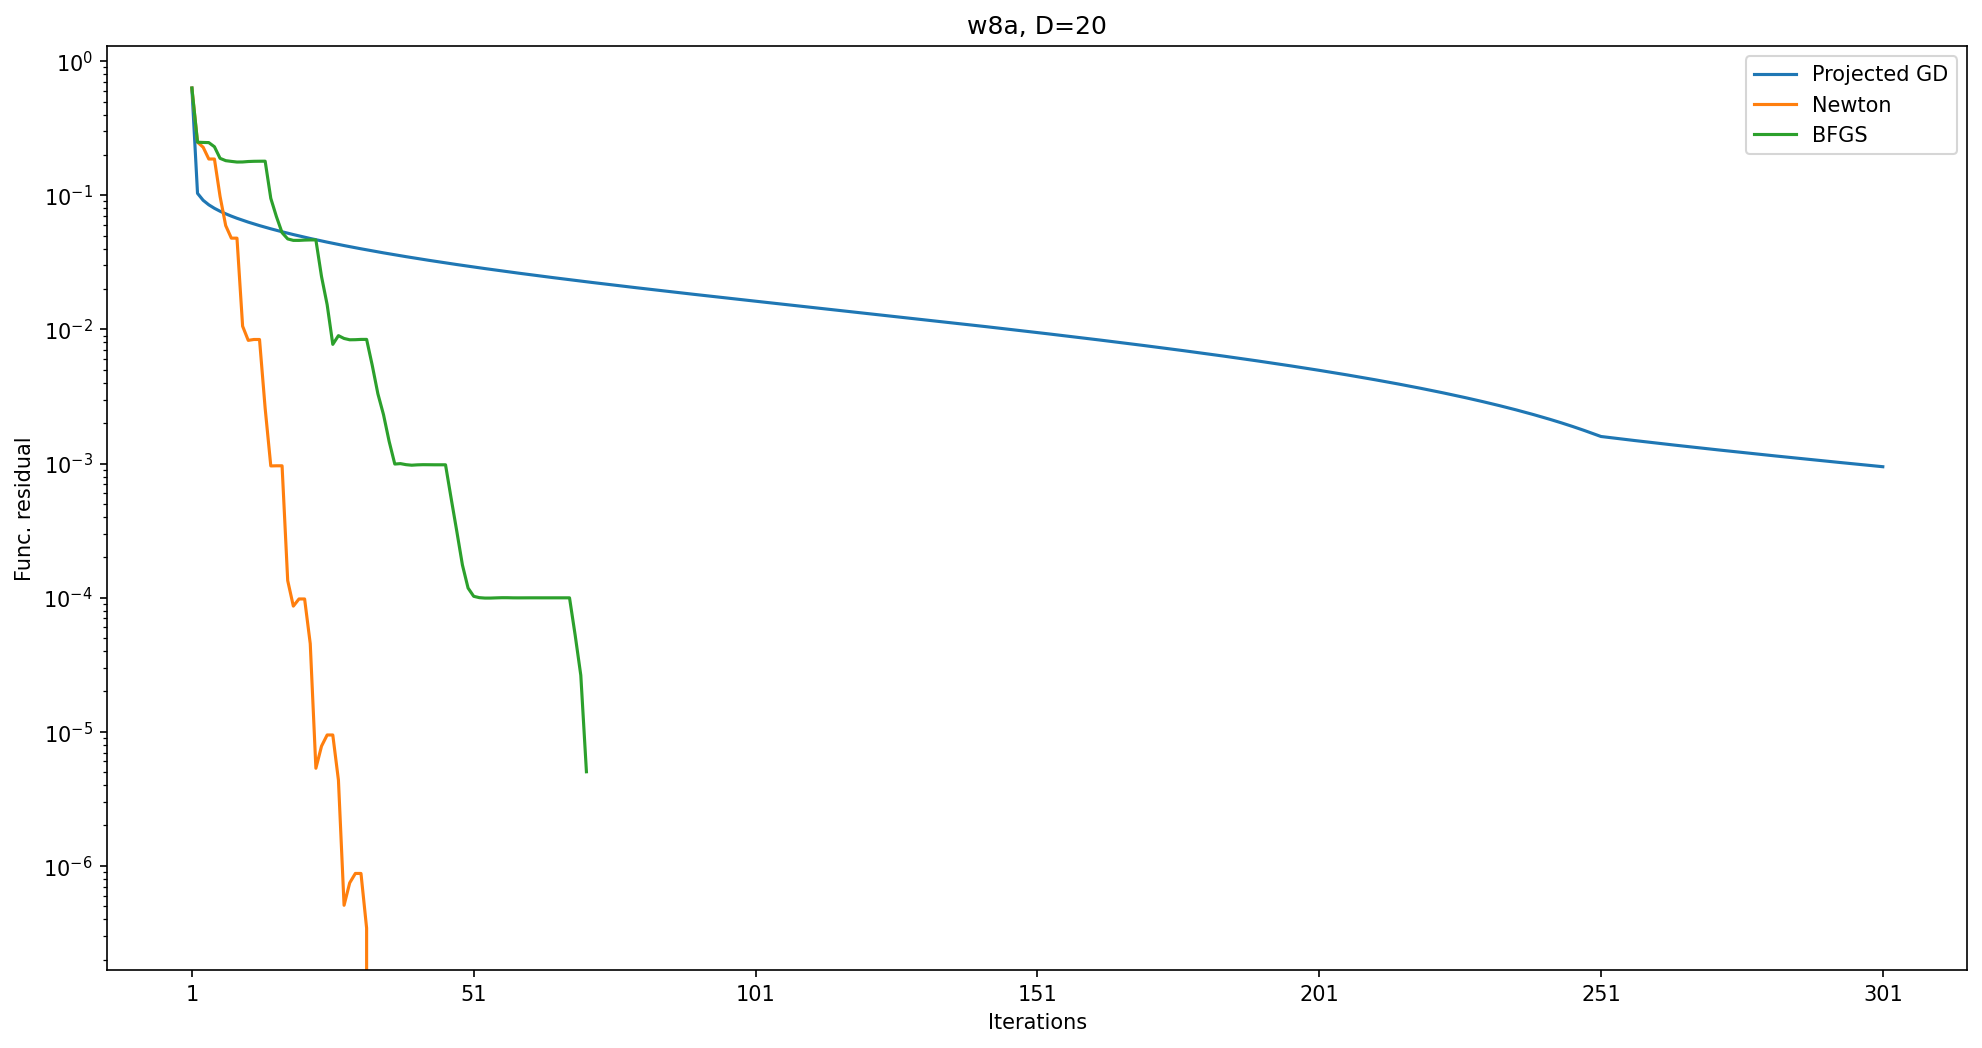

In [36]:
fval_opt = f(x_opt_ipm_damped)
fvals_pgd_seq = pd.Series(fvals_pgd-fval_opt, index=np.arange(len(fvals_pgd))+1, name=r'Projected GD')
fvals_damped_seq = pd.Series(fvals_damped-fval_opt, index=np.arange(len(fvals_damped))+1, name=r'Newton')
fvals_bfgs_seq = pd.Series(fvals_bfgs-fval_opt, index=np.arange(len(fvals_bfgs))+1, name=r'BFGS')
plot_multi_seqs([fvals_pgd_seq, fvals_damped_seq, fvals_bfgs_seq], xlabel='Iterations', ylabel=r'Func. residual', title=r'w8a, D=20', xtick_step = 50)

### CVXPY-计算 optimal value

In [49]:
# D=500
# x = cp.Variable(n)
# # objective = cp.Minimize(sum(cp.log1p(cp.exp(-b*(A@x))))/m + 1/(100*m)* x.T@x)
# # objective = cp.Minimize(sum(cp.log1p(cp.exp(-b*(A@x))))/m)
# objective = cp.Minimize(cp.norm(x)**2 + sum(cp.log1p(cp.exp(-b*(A@x))))/m)
# constraints = [cp.norm(x)<=D/2]
# problem = cp.Problem(objective,constraints)
# result = problem.solve()
# print(f'最优值: {f(x.value)}')

最优值: 0.6931471805599453


/home/lzq22/anaconda3/envs/optim/lib/python3.8/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)
